In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/socialbuzz-sentiment-analytics/sentimentdataset.csv


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("eshummalik/socialbuzz-sentiment-analytics")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/socialbuzz-sentiment-analytics


In [3]:
df = pd.read_csv(path + '/sentimentdataset.csv')
df

,Unnamed: 0.1,Unnamed: 0,Text,Sentiment,Timestamp,User,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour
0,0,0,Enjoying a beautiful day at the park! ...,Positive,2023-01-15 12:30:00,User123,Twitter,#Nature #Park,15.0,30.0,USA,2023,1,15,12
1,1,1,Traffic was terrible this morning. ...,Negative,2023-01-15 08:45:00,CommuterX,Twitter,#Traffic #Morning,5.0,10.0,Canada,2023,1,15,8
2,2,2,Just finished an amazing workout! 💪 ...,Positive,2023-01-15 15:45:00,FitnessFan,Instagram,#Fitness #Workout,20.0,40.0,USA,2023,1,15,15
3,3,3,Excited about the upcoming weekend getaway! ...,Positive,2023-01-15 18:20:00,AdventureX,Facebook,#Travel #Adventure,8.0,15.0,UK,2023,1,15,18
4,4,4,Trying out a new recipe for dinner tonight. ...,Neutral,2023-01-15 19:55:00,ChefCook,Instagram,#Cooking #Food,12.0,25.0,Australia,2023,1,15,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
727,728,732,Collaborating on a science project that receiv...,Happy,2017-08-18 18:20:00,ScienceProjectSuccessHighSchool,Facebook,#ScienceFairWinner #HighSchoolScience,20.0,39.0,UK,2017,8,18,18
728,729,733,Attending a surprise birthday party organized ...,Happy,2018-06-22 14:15:00,BirthdayPartyJoyHighSchool,Instagram,#SurpriseCelebration #HighSchoolFriendship,25.0,48.0,USA,2018,6,22,14
729,730,734,Successfully fundraising for a school charity ...,Happy,2019-04-05 17:30:00,CharityFundraisingTriumphHighSchool,Twitter,#CommunityGiving #HighSchoolPhilanthropy,22.0,42.0,Canada,2019,4,5,17
730,731,735,"Participating in a multicultural festival, cel...",Happy,2020-02-29 20:45:00,MulticulturalFestivalJoyHighSchool,Facebook,#CulturalCelebration #HighSchoolUnity,21.0,43.0,UK,2020,2,29,20


## here i just wanna sharing about LSTM step by step, here i'll explain how LSTM working by implementing practice

## LSTM Formula is 
## it = sigmoid( Xt * Wi + ht * Wri) 
## ft = sigmoid(Xt * Wf + ht * Wrf) 
## ot = sigmoid(Xt * Wo + ht * wro) 
## gt = tanh(Wt * Wg + ht * wrg) 
## ct = ft * c[t-1] + it * gt
## ht = ot * tanh(ct)

In [28]:
from torch import nn 
import torch
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences 

In [116]:
class LSTM (nn.Module) :
    def __init__ (self,embed_dim,return_sequence = True,return_state=False) :
        super().__init__()
        ## this is how we applying weight for gating mechanism 
        std = (2 / (embed_dim * 2)) **0.5
        self.wi = nn.Parameter(
            torch.normal(0,std,(embed_dim,embed_dim))
        )
        self.wf = nn.Parameter(
            torch.normal(0,std,(embed_dim,embed_dim))
        )
        self.wg = nn.Parameter(
            torch.normal(0,std,(embed_dim,embed_dim))
        )
        self.wo = nn.Parameter(
            torch.normal(0,std,(embed_dim,embed_dim))
        )
        ## here we need implemented weight recurrent by orthogonal init 
        ## for matching hidden state with main logits 
        self.wir = nn.Linear(embed_dim,embed_dim,bias=False)
        self.wfr = nn.Linear(embed_dim,embed_dim,bias=False)
        self.wor = nn.Linear(embed_dim,embed_dim,bias=False)
        self.wgr = nn.Linear(embed_dim,embed_dim,bias=False)
        nn.init.orthogonal_(self.wir.weight)
        nn.init.orthogonal_(self.wfr.weight)
        nn.init.orthogonal_(self.wor.weight)
        nn.init.orthogonal_(self.wgr.weight)

        self.return_state = return_state 
        self.return_sequence = return_sequence

    def forward (self,x,state = None ) :
        b,t,d = x.shape
        if state is not None :
            hd,cs = state 
        else :
            hd = torch.zeros((b,d))
            cs =  torch.zeros((b,d))
        output = list()

        ## we do looping inference to (token[0]..token[1]) as timesteps 
        ## and here, is a how LSTM working .. and 
        ## conratulation you has implementing real LSTM and is not toy Layers 
        ## you has implemented real LSTM for real training 
        
        for i in range(t) :
            xi = x[:,i,:]
            it = torch.sigmoid(torch.matmul(xi,self.wi) + self.wir(hd))
            ft = torch.sigmoid(torch.matmul(xi,self.wf) + self.wfr(hd))
            ot = torch.sigmoid(torch.matmul(xi,self.wo) + self.wor(hd))
            gt = torch.tanh(torch.matmul(xi,self.wg) + self.wgr(hd))
            ct_n = ft * cs + it * gt 
            cs = ct_n 
            hd = ot * torch.tanh(cs)
            output.append(hd.reshape(b,1,d))

        output = torch.concat(output,dim=1)
        
        
        if self.return_sequence and self.return_state :
            return output,[hd,cs]
        if self.return_sequence and not self.return_state :
            return output 
        if not self.return_sequence and self.return_state :
            return output[:,-1,:],[hd,cs]
        if not self.return_sequence and not self.return_state :
            return output[:,-1,:]
            
         

# Lets Testing first

In [117]:
class Model (nn.Module) :
    def __init__ (self,vocab_size,embed_dim,num_class) :
        super().__init__()
        self.embedding = nn.Embedding(vocab_size,embed_dim)
        self.lstm = LSTM(embed_dim)
        self.linear1 = nn.Linear(embed_dim,embed_dim*2)
        self.linear2 = nn.Linear(embed_dim * 2,embed_dim)
        self.fo = nn.Linear(embed_dim,num_class)

    def forward(self,x) :
        x = self.embedding(x)
        x = self.lstm(x)
        x = self.linear1(x)
        x = self.linear2(x)
        x = torch.mean(x,dim=1)
        return self.fo(x)  

In [63]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df.Sentiment.to_list())
tokenizer.fit_on_texts(df.Text.to_list())

In [57]:
from sklearn.preprocessing import LabelEncoder

In [105]:
class dataset (torch.utils.data.Dataset) :
    def __init__(self) :
        super().__init__()
        self.texts = df.Text.to_list()
        label = LabelEncoder().fit_transform(df.Sentiment.to_list())
        self.label = torch.tensor(label,dtype=torch.long)

    def __getitem__(self,idx) :
        x = tokenizer.texts_to_sequences([self.texts[idx]])
        x = pad_sequences(x,padding='post',maxlen=20)[0]
        y = self.label[idx]
        return torch.tensor(x),y
    def __len__(self) :
        return len(self.texts)

In [106]:
datasets = dataset()
dataloaded = torch.utils.data.DataLoader(datasets,32,True)

In [98]:
len(tokenizer.word_index) + 1

2610

In [118]:
model = Model(2610,32,279)
model.train(True)
optim = torch.optim.Adam(model.parameters())
loss_fn = nn.CrossEntropyLoss()
from tqdm import tqdm 
hist = []

In [119]:
epochs = 100
for epoch in range(epochs) :
    iterator = tqdm(dataloaded)
    loss_total = 0 
    for x,y in iterator :
        y_pred = model(x)
        loss = loss_fn(y_pred,y)
        optim.zero_grad()
        loss.backward()
        optim.step()
        loss_total += loss.item()
        iterator.set_description(f"epoch : {epoch + 1} / {epochs}")
        iterator.set_postfix(loss = loss.item())
    loss_total = loss_total /  len(dataloaded)
    hist.append(loss_total)
    print(f"average loss : {loss_total}")

epoch : 1 / 100: 100%|██████████| 23/23 [00:00<00:00, 39.56it/s, loss=5.62]


average loss : 5.6115634752356485


epoch : 2 / 100: 100%|██████████| 23/23 [00:00<00:00, 38.82it/s, loss=5.26]


average loss : 5.486031428627346


epoch : 3 / 100: 100%|██████████| 23/23 [00:00<00:00, 40.30it/s, loss=5.09]


average loss : 5.270048639048701


epoch : 4 / 100: 100%|██████████| 23/23 [00:00<00:00, 40.14it/s, loss=5.07]


average loss : 5.127626191014829


epoch : 5 / 100: 100%|██████████| 23/23 [00:00<00:00, 41.07it/s, loss=5]   


average loss : 4.977475311445153


epoch : 6 / 100: 100%|██████████| 23/23 [00:00<00:00, 40.71it/s, loss=4.46]


average loss : 4.780048743538234


epoch : 7 / 100: 100%|██████████| 23/23 [00:00<00:00, 40.48it/s, loss=4.61]


average loss : 4.596979493680208


epoch : 8 / 100: 100%|██████████| 23/23 [00:00<00:00, 39.17it/s, loss=4.46]


average loss : 4.433906099070674


epoch : 9 / 100: 100%|██████████| 23/23 [00:00<00:00, 40.66it/s, loss=4.78]


average loss : 4.31144931005395


epoch : 10 / 100: 100%|██████████| 23/23 [00:00<00:00, 41.61it/s, loss=4.38]


average loss : 4.207765371903129


epoch : 11 / 100: 100%|██████████| 23/23 [00:00<00:00, 40.19it/s, loss=4.05]


average loss : 4.109330094378928


epoch : 12 / 100: 100%|██████████| 23/23 [00:00<00:00, 41.22it/s, loss=3.79]


average loss : 4.007756575294163


epoch : 13 / 100: 100%|██████████| 23/23 [00:00<00:00, 41.89it/s, loss=3.75]


average loss : 3.9116746653681216


epoch : 14 / 100: 100%|██████████| 23/23 [00:00<00:00, 41.92it/s, loss=3.79]


average loss : 3.8101773883985435


epoch : 15 / 100: 100%|██████████| 23/23 [00:00<00:00, 41.31it/s, loss=3.89]


average loss : 3.731351240821507


epoch : 16 / 100: 100%|██████████| 23/23 [00:00<00:00, 40.68it/s, loss=3.31]


average loss : 3.6326603371164072


epoch : 17 / 100: 100%|██████████| 23/23 [00:00<00:00, 36.91it/s, loss=4.01]


average loss : 3.532249129336813


epoch : 18 / 100: 100%|██████████| 23/23 [00:00<00:00, 40.63it/s, loss=3.7] 


average loss : 3.4378465569537617


epoch : 19 / 100: 100%|██████████| 23/23 [00:00<00:00, 41.15it/s, loss=3.16]


average loss : 3.3492610454559326


epoch : 20 / 100: 100%|██████████| 23/23 [00:00<00:00, 39.97it/s, loss=3.03]


average loss : 3.251535882120547


epoch : 21 / 100: 100%|██████████| 23/23 [00:00<00:00, 40.07it/s, loss=3.4] 


average loss : 3.17729665922082


epoch : 22 / 100: 100%|██████████| 23/23 [00:00<00:00, 40.60it/s, loss=3.15]


average loss : 3.081657026125037


epoch : 23 / 100: 100%|██████████| 23/23 [00:00<00:00, 40.80it/s, loss=2.78]


average loss : 2.9881348091623057


epoch : 24 / 100: 100%|██████████| 23/23 [00:00<00:00, 40.90it/s, loss=3.05]


average loss : 2.9080657958984375


epoch : 25 / 100: 100%|██████████| 23/23 [00:00<00:00, 40.55it/s, loss=2.84]


average loss : 2.827625139899876


epoch : 26 / 100: 100%|██████████| 23/23 [00:00<00:00, 41.03it/s, loss=3.04]


average loss : 2.711134143497633


epoch : 27 / 100: 100%|██████████| 23/23 [00:00<00:00, 41.18it/s, loss=2.46]


average loss : 2.587132505748583


epoch : 28 / 100: 100%|██████████| 23/23 [00:00<00:00, 41.58it/s, loss=2.62]


average loss : 2.4742433921150537


epoch : 29 / 100: 100%|██████████| 23/23 [00:00<00:00, 40.72it/s, loss=2.12]


average loss : 2.366718484007794


epoch : 30 / 100: 100%|██████████| 23/23 [00:00<00:00, 40.59it/s, loss=2.4] 


average loss : 2.25119205661442


epoch : 31 / 100: 100%|██████████| 23/23 [00:00<00:00, 40.84it/s, loss=2.08]


average loss : 2.116126236708268


epoch : 32 / 100: 100%|██████████| 23/23 [00:00<00:00, 40.51it/s, loss=2.12]


average loss : 2.006104453750279


epoch : 33 / 100: 100%|██████████| 23/23 [00:00<00:00, 40.68it/s, loss=2.12]


average loss : 1.9049936273823613


epoch : 34 / 100: 100%|██████████| 23/23 [00:00<00:00, 40.11it/s, loss=1.77]


average loss : 1.7786751881889675


epoch : 35 / 100: 100%|██████████| 23/23 [00:00<00:00, 37.22it/s, loss=2.05]


average loss : 1.663652295651643


epoch : 36 / 100: 100%|██████████| 23/23 [00:00<00:00, 40.24it/s, loss=1.78]


average loss : 1.5582806234774382


epoch : 37 / 100: 100%|██████████| 23/23 [00:00<00:00, 41.20it/s, loss=1.65]


average loss : 1.4661226583563762


epoch : 38 / 100: 100%|██████████| 23/23 [00:00<00:00, 41.50it/s, loss=1.31]


average loss : 1.3757626466129138


epoch : 39 / 100: 100%|██████████| 23/23 [00:00<00:00, 40.65it/s, loss=1.03]


average loss : 1.274883710819742


epoch : 40 / 100: 100%|██████████| 23/23 [00:00<00:00, 41.15it/s, loss=1.53] 


average loss : 1.1882469628168189


epoch : 41 / 100: 100%|██████████| 23/23 [00:00<00:00, 42.24it/s, loss=1.53] 


average loss : 1.1187011184899702


epoch : 42 / 100: 100%|██████████| 23/23 [00:00<00:00, 40.80it/s, loss=0.752]


average loss : 1.0349814891815186


epoch : 43 / 100: 100%|██████████| 23/23 [00:00<00:00, 40.22it/s, loss=0.717]


average loss : 0.9431600726169088


epoch : 44 / 100: 100%|██████████| 23/23 [00:00<00:00, 40.95it/s, loss=0.762]


average loss : 0.8868509842001874


epoch : 45 / 100: 100%|██████████| 23/23 [00:00<00:00, 41.61it/s, loss=0.951]


average loss : 0.8153434110724408


epoch : 46 / 100: 100%|██████████| 23/23 [00:00<00:00, 41.09it/s, loss=0.631]


average loss : 0.7636116276616636


epoch : 47 / 100: 100%|██████████| 23/23 [00:00<00:00, 41.67it/s, loss=0.66] 


average loss : 0.6950084191301594


epoch : 48 / 100: 100%|██████████| 23/23 [00:00<00:00, 40.73it/s, loss=0.461]


average loss : 0.6346678150736768


epoch : 49 / 100: 100%|██████████| 23/23 [00:00<00:00, 41.12it/s, loss=0.609]


average loss : 0.5788627111393473


epoch : 50 / 100: 100%|██████████| 23/23 [00:00<00:00, 39.85it/s, loss=0.754]


average loss : 0.5765250804631606


epoch : 51 / 100: 100%|██████████| 23/23 [00:00<00:00, 40.45it/s, loss=0.88] 


average loss : 0.5882300086643385


epoch : 52 / 100: 100%|██████████| 23/23 [00:00<00:00, 36.74it/s, loss=0.847]


average loss : 0.5779216768948928


epoch : 53 / 100: 100%|██████████| 23/23 [00:00<00:00, 41.08it/s, loss=0.734]


average loss : 0.5126541023669036


epoch : 54 / 100: 100%|██████████| 23/23 [00:00<00:00, 39.31it/s, loss=0.405]


average loss : 0.4465835884861324


epoch : 55 / 100: 100%|██████████| 23/23 [00:00<00:00, 40.01it/s, loss=0.354]


average loss : 0.3937244577252347


epoch : 56 / 100: 100%|██████████| 23/23 [00:00<00:00, 40.50it/s, loss=0.317]


average loss : 0.34854049332763837


epoch : 57 / 100: 100%|██████████| 23/23 [00:00<00:00, 39.90it/s, loss=0.492]


average loss : 0.35368512246919714


epoch : 58 / 100: 100%|██████████| 23/23 [00:00<00:00, 40.00it/s, loss=0.469]


average loss : 0.2986624072427335


epoch : 59 / 100: 100%|██████████| 23/23 [00:00<00:00, 40.49it/s, loss=0.246]


average loss : 0.25249608962432196


epoch : 60 / 100: 100%|██████████| 23/23 [00:00<00:00, 40.18it/s, loss=0.415]


average loss : 0.22296046044515527


epoch : 61 / 100: 100%|██████████| 23/23 [00:00<00:00, 39.95it/s, loss=0.22] 


average loss : 0.19646428363478702


epoch : 62 / 100: 100%|██████████| 23/23 [00:00<00:00, 40.24it/s, loss=0.302]


average loss : 0.22181202082530313


epoch : 63 / 100: 100%|██████████| 23/23 [00:00<00:00, 40.80it/s, loss=0.405]


average loss : 0.3135332588268363


epoch : 64 / 100: 100%|██████████| 23/23 [00:00<00:00, 39.57it/s, loss=0.302]


average loss : 0.25644284810708917


epoch : 65 / 100: 100%|██████████| 23/23 [00:00<00:00, 40.16it/s, loss=0.352]


average loss : 0.2083042072861091


epoch : 66 / 100: 100%|██████████| 23/23 [00:00<00:00, 40.29it/s, loss=0.161] 


average loss : 0.18033451424992603


epoch : 67 / 100: 100%|██████████| 23/23 [00:00<00:00, 39.17it/s, loss=0.186] 


average loss : 0.15593999494677005


epoch : 68 / 100: 100%|██████████| 23/23 [00:00<00:00, 40.07it/s, loss=0.206] 


average loss : 0.12038242590168248


epoch : 69 / 100: 100%|██████████| 23/23 [00:00<00:00, 35.99it/s, loss=0.13]  


average loss : 0.10603457656891449


epoch : 70 / 100: 100%|██████████| 23/23 [00:00<00:00, 40.96it/s, loss=0.0697]


average loss : 0.0922543263953665


epoch : 71 / 100: 100%|██████████| 23/23 [00:00<00:00, 40.27it/s, loss=0.115] 


average loss : 0.08351418991451678


epoch : 72 / 100: 100%|██████████| 23/23 [00:00<00:00, 40.40it/s, loss=0.0766]


average loss : 0.0790423686089723


epoch : 73 / 100: 100%|██████████| 23/23 [00:00<00:00, 41.24it/s, loss=0.0458]


average loss : 0.07209835784590762


epoch : 74 / 100: 100%|██████████| 23/23 [00:00<00:00, 41.25it/s, loss=0.0323]


average loss : 0.06814967128245727


epoch : 75 / 100: 100%|██████████| 23/23 [00:00<00:00, 41.47it/s, loss=0.0383]


average loss : 0.061165430299613785


epoch : 76 / 100: 100%|██████████| 23/23 [00:00<00:00, 40.94it/s, loss=0.0507]


average loss : 0.05915741031260594


epoch : 77 / 100: 100%|██████████| 23/23 [00:00<00:00, 41.01it/s, loss=0.0498]


average loss : 0.05504352461708629


epoch : 78 / 100: 100%|██████████| 23/23 [00:00<00:00, 40.44it/s, loss=0.0366]


average loss : 0.0508685197033312


epoch : 79 / 100: 100%|██████████| 23/23 [00:00<00:00, 40.84it/s, loss=0.0521]


average loss : 0.04938791133463383


epoch : 80 / 100: 100%|██████████| 23/23 [00:00<00:00, 41.14it/s, loss=0.0373]


average loss : 0.04698158873488074


epoch : 81 / 100: 100%|██████████| 23/23 [00:00<00:00, 40.77it/s, loss=0.0412]


average loss : 0.04654281416341015


epoch : 82 / 100: 100%|██████████| 23/23 [00:00<00:00, 40.82it/s, loss=0.0314]


average loss : 0.04303110196538593


epoch : 83 / 100: 100%|██████████| 23/23 [00:00<00:00, 40.99it/s, loss=0.0264]


average loss : 0.03977479056819626


epoch : 84 / 100: 100%|██████████| 23/23 [00:00<00:00, 41.17it/s, loss=0.0297]


average loss : 0.03681326390284559


epoch : 85 / 100: 100%|██████████| 23/23 [00:00<00:00, 40.76it/s, loss=0.0335]


average loss : 0.036765052491556045


epoch : 86 / 100: 100%|██████████| 23/23 [00:00<00:00, 40.78it/s, loss=0.0299]


average loss : 0.03414606570225695


epoch : 87 / 100: 100%|██████████| 23/23 [00:00<00:00, 37.62it/s, loss=0.0239]


average loss : 0.03418330670050953


epoch : 88 / 100: 100%|██████████| 23/23 [00:00<00:00, 41.12it/s, loss=0.0218]


average loss : 0.030403652430876442


epoch : 89 / 100: 100%|██████████| 23/23 [00:00<00:00, 40.82it/s, loss=0.0238]


average loss : 0.0282440726523814


epoch : 90 / 100: 100%|██████████| 23/23 [00:00<00:00, 40.88it/s, loss=0.0258]


average loss : 0.03136803987233535


epoch : 91 / 100: 100%|██████████| 23/23 [00:00<00:00, 41.30it/s, loss=0.0207]


average loss : 0.02805057305680669


epoch : 92 / 100: 100%|██████████| 23/23 [00:00<00:00, 41.07it/s, loss=0.107] 


average loss : 0.027357761221735374


epoch : 93 / 100: 100%|██████████| 23/23 [00:00<00:00, 41.29it/s, loss=0.0208]


average loss : 0.027091098908820877


epoch : 94 / 100: 100%|██████████| 23/23 [00:00<00:00, 41.02it/s, loss=0.0176]


average loss : 0.023204516821905323


epoch : 95 / 100: 100%|██████████| 23/23 [00:00<00:00, 40.38it/s, loss=0.0217]


average loss : 0.025452712267313316


epoch : 96 / 100: 100%|██████████| 23/23 [00:00<00:00, 40.33it/s, loss=0.017] 


average loss : 0.02871837993354901


epoch : 97 / 100: 100%|██████████| 23/23 [00:00<00:00, 41.21it/s, loss=0.0332]


average loss : 0.02778955771709266


epoch : 98 / 100: 100%|██████████| 23/23 [00:00<00:00, 40.73it/s, loss=0.0201]


average loss : 0.021746882682909138


epoch : 99 / 100: 100%|██████████| 23/23 [00:00<00:00, 38.93it/s, loss=0.0204]


average loss : 0.021462440409738083


epoch : 100 / 100: 100%|██████████| 23/23 [00:00<00:00, 40.13it/s, loss=0.0236]


average loss : 0.022012675504969513


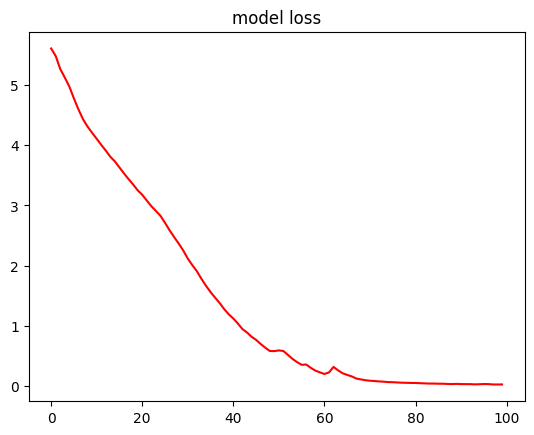

In [120]:
import matplotlib.pyplot as plt
plt.title("model loss")
plt.plot(hist,color='red')